---
# Imports

In [1]:
import os
# Ensure deterministic behavior for reproducibility
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

import json
from rich import print as rprint
import pandas as pd
import numpy as np

import warnings
# Filter the specific UserWarning from torch regarding TF32/matmul precision
warnings.filterwarnings("ignore", category=UserWarning, module="torch")

import torch
torch.set_float32_matmul_precision('high')
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes, make_rgb_axes
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold

import cv2
import pickle

import logging
import time
from datetime import datetime
import gc # garbage collection to free up memory

print('OpenCV version: ', cv2.__version__)


OpenCV version:  4.12.0


In [2]:
import random
import os

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # torch.use_deterministic_algorithms(True, warn_only=True)

SEED = 42

seed_everything(SEED)


---
# Load data

In [3]:
# Read Training Data CSV
df_train = pd.read_csv('../data/raw/Training/Train.csv')

In [4]:
# Drop image 332 due to corrupted file
df_train = df_train[df_train['image_id'] != 332].reset_index(drop=True)

In [5]:
# Load augmented data - global

with open('../data/processed/augmented/augmented_train_masked_global_480.pkl', 'rb') as f:
    aug_train_global = pickle.load(f)


In [6]:
# Load augmented data - local

with open('../data/processed/augmented/augmented_train_masked_local_depth_480.pkl', 'rb') as f:
    aug_train_local = pickle.load(f)


In [7]:
def consolidate_dual_depth(local_array, global_array):
    """
    Merges local and global augmented arrays into one dual-channel array.
    Assumes arrays are ordered identically or mapped by image_id.
    """
    # Create a lookup for global depth to ensure alignment
    global_lookup = {s['image_id']: s['depth_image'] for s in global_array}
    
    dual_array = []
    for s in local_array:
        new_item = s.copy()
        # Rename the existing local depth and add the global one
        new_item['depth_local'] = s['depth_image']
        new_item['depth_global'] = global_lookup[s['image_id']]
        
        # Clean up the old key to save memory
        del new_item['depth_image']
        
        dual_array.append(new_item)
    
    return dual_array

# Create the unified arrays
aug_train_dual = consolidate_dual_depth(aug_train_local, aug_train_global)


---

In [8]:
# Ensuring all 31 versions of an image are together in the train/val split (avoid data leakage between sets)
# Stratify by bins of FreshWeightShoot
# Stratify by Variety

In [9]:
def prepare_folds_from_array(aug_array, n_splits=5):
    """
    Groups augmented samples by image_id and assigns folds 
    stratified by Variety and DryWeightShoot bins.
    """
    # 1. Extract metadata for the 230 unique plants
    items = []
    seen_ids = set()
    for s in aug_array:
        if s['image_id'] not in seen_ids:
            items.append({
                'image_id': s['image_id'],
                'dry_weight': s['dry_weight'],
                'variety': s['variety']
            })
            seen_ids.add(s['image_id'])
    
    df_meta = pd.DataFrame(items)

    # 2. Create stratification bins based on DSW
    df_meta['weight_bin'] = pd.qcut(df_meta['dry_weight'], q=10, labels=False, duplicates='drop')
    
    # 3. Create composite key (Variety + Weight)
    df_meta['stratify_key'] = df_meta['variety'].astype(str) + "_" + df_meta['weight_bin'].astype(str)
    
    # 4. Perform Stratified Group K-Fold
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    df_meta['fold'] = -1
    
    for fold, (_, val_idx) in enumerate(sgkf.split(df_meta, df_meta['stratify_key'], groups=df_meta['image_id'])):
        df_meta.loc[df_meta.index[val_idx], 'fold'] = fold
        
    return dict(zip(df_meta['image_id'], df_meta['fold'])), df_meta

def get_fold_data(aug_array, fold_map, fold_index):
    """
    Uses the fold_map to split the full augmented array.
    """
    fold_train = [s for s in aug_array if fold_map[s['image_id']] != fold_index]
    fold_val = [s for s in aug_array if fold_map[s['image_id']] == fold_index]
            
    return fold_train, fold_val

/home/grant/.pyenv/versions/3.10.16/lib/python3.10/site-packages/sklearn/model_selection/_split.py:1023: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Variety Distribution per Fold:
variety  Aphylion  Lugano  Salanova  Satine
fold                                       
0              12       9        12      13
1              11      13        12      10
2              11      13        11      11
3               9      10        13      14
4              12      12        12      10

Fold 0 Summary:
Training Samples: 5704 (approx 184 unique plants)
Validation Samples: 1426 (approx 46 unique plants)


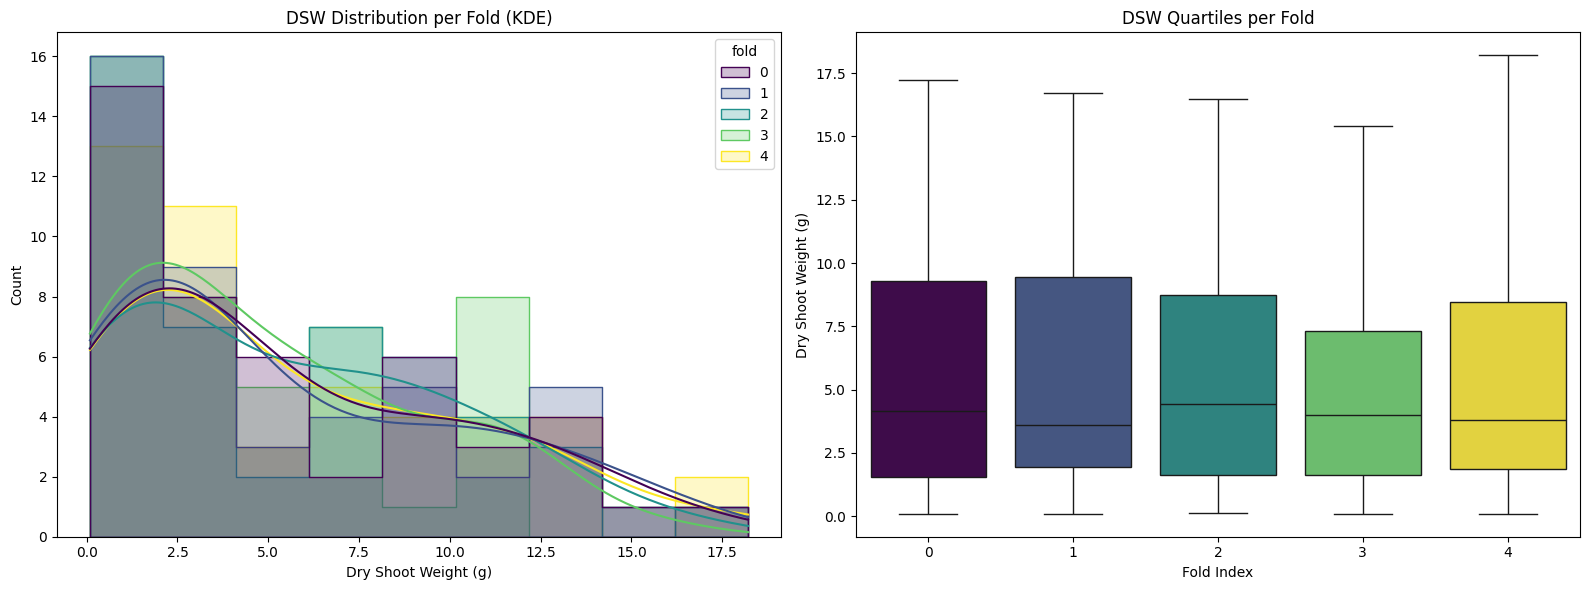

In [10]:
# 1. Use the specialist fold preparation (stratifies by weight)
# variety_data contains ONLY the samples for this variety
fold_map, df_meta = prepare_folds_from_array(aug_train_dual, n_splits=5)

# 2. Print Sanity Checks
print("Variety Distribution per Fold:")
print(pd.crosstab(df_meta['fold'], df_meta['variety']))

# 3. Fetching data for the first fold
fold0_train, fold0_val = get_fold_data(aug_train_dual, fold_map, fold_index=0)

print(f"\nFold 0 Summary:")
print(f"Training Samples: {len(fold0_train)} (approx {len(fold0_train)//31} unique plants)")
print(f"Validation Samples: {len(fold0_val)} (approx {len(fold0_val)//31} unique plants)")

# 4. Visualization

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Histogram of Dry Shoot Weight per Fold
# Changed 'DryWeightShoot' to 'dry_weight' to match df_meta keys
sns.histplot(data=df_meta, x='dry_weight', hue='fold', 
                element="step", palette='viridis', kde=True, 
                ax=axes[0])
axes[0].set_title('DSW Distribution per Fold (KDE)')
axes[0].set_xlabel('Dry Shoot Weight (g)')

# Plot 2: Box Plot for Quartile Comparison
# Changed 'DryWeightShoot' to 'dry_weight' to match df_meta keys
sns.boxplot(data=df_meta, x='fold', y='dry_weight', 
            hue='fold', palette='viridis', legend=False, ax=axes[1])
axes[1].set_title('DSW Quartiles per Fold')
axes[1].set_ylabel('Dry Shoot Weight (g)')
axes[1].set_xlabel('Fold Index')

plt.tight_layout()
plt.show()

---
# Metrics

In [11]:
from sklearn.metrics import r2_score

class MetricTracker:
    def __init__(self, use_log=True):
        self.use_log = use_log
        self.reset()

    def reset(self):
        self.preds = []
        self.targets = []

    def update(self, pred_log, target_log):
        if self.use_log:
            preds = torch.exp(pred_log)
            targets = torch.exp(target_log)
        else:
            preds = pred_log
            targets = target_log

        self.preds.append(preds.detach().cpu())
        self.targets.append(targets.detach().cpu())

    def calculate(self):
        preds = torch.cat(self.preds).numpy()
        targets = torch.cat(self.targets).numpy()

        mae = np.mean(np.abs(preds - targets))
        mape = np.mean(np.abs((preds - targets) / (targets + 1e-8))) * 100
        rmse = np.sqrt(np.mean((preds - targets) ** 2))
        nrmse = rmse / (targets.mean() + 1e-8)

        ss_res = np.sum((targets - preds) ** 2)
        ss_tot = np.sum((targets - targets.mean()) ** 2)
        r2 = 1 - ss_res / (ss_tot + 1e-8)

        return {
            "MAE": mae,
            "MAPE": mape,
            "NRMSE": nrmse,
            "R2": r2
        }

---
---
# RGB + D + MIF

In [12]:
# Log-space training, per-sample reweighting, variety indexing and metric evaluation in original grams (not log-space)

class LettuceDualDepthDataset(Dataset):
    def __init__(self, data_list, 
                 variety_to_idx=None,
                 use_log=True,
                 reweight=False):

        self.data = data_list
        self.use_log = use_log
        self.variety_to_idx = variety_to_idx

        # Standard ImageNet stats for the RGB branch
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])

        # ---- Build weights (optional) ----
        if reweight:
            weights_raw = np.array([d['dry_weight'] for d in data_list])
            
            # Decile bins
            bins = np.quantile(weights_raw, np.linspace(0,1,11))
            bin_ids = np.digitize(weights_raw, bins[1:-1])
            counts = np.bincount(bin_ids)
            
            w = 1.0 / counts[bin_ids]
            self.sample_weights = w / w.mean()
        else:
            self.sample_weights = np.ones(len(data_list))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        
        # --- RGB Branch ---
        rgb = item['rgb_image']
        rgb = rgb.astype(np.float32) / 255.0
        rgb = (rgb - self.mean) / self.std
        rgb = np.transpose(rgb, (2, 0, 1))
        
        # --- Depth Branch ---
        # Dual-Depth Stacking
        d_global = item['depth_global'].astype(np.float32)
        d_local = item['depth_local'].astype(np.float32)
         # Ensure they are in [0, 1] range if not already
        if d_global.max() > 1.0: d_global /= 255.0
        if d_local.max() > 1.0: d_local /= 255.0
        # Stack into [2, 480, 480] tensor
        dual_depth = np.stack([d_global, d_local], axis=0)
            
        target = float(item['dry_weight'])
        if self.use_log:
            target = np.log(target + 1e-8)

         # --- Variety ---
        if self.variety_to_idx is not None:
            variety_idx = self.variety_to_idx[item['variety']]
        else:
            variety_idx = 0  # safe dummy index

        return {
            'rgb': torch.tensor(rgb, dtype=torch.float32),
            'depth': torch.tensor(dual_depth, dtype=torch.float32),
            'target': torch.tensor(target, dtype=torch.float32),
            'weight': torch.tensor(self.sample_weights[idx], dtype=torch.float32),
            'variety_idx': torch.tensor(variety_idx, dtype=torch.long),
            'image_id': item['image_id']
        }


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm


# ------------------------------------------------------------
# Cross-Modal Fusion Block 
# ------------------------------------------------------------
class DCMFBlock(nn.Module):
    def __init__(self, rgb_ch, depth_ch):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Modality Importance Fusion (MIF)
        self.mif_fc = nn.Sequential(
            nn.Linear(rgb_ch + depth_ch, (rgb_ch + depth_ch) // 2),
            nn.ReLU(inplace=True),
            nn.Linear((rgb_ch + depth_ch) // 2, 2),
            nn.Softmax(dim=1)
        )

        # Channel projection layers
        self.project_d_to_r = nn.Conv2d(depth_ch, rgb_ch, kernel_size=1)
        self.project_r_to_d = nn.Conv2d(rgb_ch, depth_ch, kernel_size=1)

    def forward(self, f_rgb, f_depth):
        b, c_r, h_r, w_r = f_rgb.size()
        b, c_d, h_d, w_d = f_depth.size()

        # ---- Compute modality weights ----
        rgb_vec = self.gap(f_rgb).view(b, -1)
        depth_vec = self.gap(f_depth).view(b, -1)

        weights = self.mif_fc(torch.cat([rgb_vec, depth_vec], dim=1))
        w_rgb = weights[:, 0].view(b, 1, 1, 1)
        w_depth = weights[:, 1].view(b, 1, 1, 1)

        # ---- Cross-modality exchange ----
        depth_to_rgb = self.project_d_to_r(
            F.interpolate(f_depth, size=(h_r, w_r), mode='bilinear', align_corners=False)
        )

        rgb_to_depth = self.project_r_to_d(
            F.interpolate(f_rgb, size=(h_d, w_d), mode='bilinear', align_corners=False)
        )

        f_rgb_out = f_rgb + (w_depth * depth_to_rgb)
        f_depth_out = f_depth + (w_rgb * rgb_to_depth)

        return f_rgb_out, f_depth_out

# ------------------------------------------------------------
# Monotonic Head (for Depth)
# ------------------------------------------------------------

class MonotonicLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight_raw = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        # Enforce non-negative weights
        weight = torch.relu(self.weight_raw)
        return F.linear(x, weight, self.bias)


# ------------------------------------------------------------
# Full RGB + Dual Depth + Variety Model
# ------------------------------------------------------------
class LFWNet_MonotonicDepth(nn.Module):
    def __init__(self, num_varieties, variety_emb_dim=8):
        super().__init__()

        # ---------------- Backbones ----------------
        self.rgb_backbone = timm.create_model(
            'legacy_seresnet18.in1k',
            pretrained=True,
            features_only=True
        )

        self.depth_backbone = timm.create_model(
            'mobilenetv3_small_100',
            pretrained=True,
            in_chans=2,
            features_only=True
        )

        rgb_chs = self.rgb_backbone.feature_info.channels()
        depth_chs = self.depth_backbone.feature_info.channels()

        # ---------------- Fusion ----------------
        self.fuse1 = DCMFBlock(rgb_chs[1], depth_chs[1])
        self.fuse2 = DCMFBlock(rgb_chs[2], depth_chs[2])
        self.fuse3 = DCMFBlock(rgb_chs[3], depth_chs[3])
        self.fuse4 = DCMFBlock(rgb_chs[4], depth_chs[4])

        self.gap = nn.AdaptiveAvgPool2d(1)

        # ---------------- Variety Embedding ----------------
        self.variety_embedding = nn.Embedding(num_varieties, variety_emb_dim)

        # ---------------- Monotonic Depth Head ----------------
        depth_dim = depth_chs[4]

        self.depth_head = nn.Sequential(
            MonotonicLinear(depth_dim, 64),
            nn.ReLU(),
            MonotonicLinear(64, 1)
        )

        # ---------------- Free RGB + Variety Head ----------------
        rgb_dim = rgb_chs[4] + variety_emb_dim

        self.rgb_head = nn.Sequential(
            nn.Linear(rgb_dim, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x_rgb, x_depth, variety_idx):

        # Backbone features
        r_list = self.rgb_backbone(x_rgb)
        d_list = self.depth_backbone(x_depth)

        r1, d1 = self.fuse1(r_list[1], d_list[1])
        r2, d2 = self.fuse2(r_list[2], d_list[2])
        r3, d3 = self.fuse3(r_list[3], d_list[3])
        r4, d4 = self.fuse4(r_list[4], d_list[4])

        # Global pooled features
        r_feat = self.gap(r4).view(r4.size(0), -1)
        d_feat = self.gap(d4).view(d4.size(0), -1)

        # Depth monotonic branch
        depth_out = self.depth_head(d_feat)

        # RGB + variety branch
        v_emb = self.variety_embedding(variety_idx)
        rgb_input = torch.cat([r_feat, v_emb], dim=1)
        rgb_out = self.rgb_head(rgb_input)

        # Final prediction (log space if training that way)
        return (depth_out + rgb_out).squeeze(1)

In [14]:
# weight loss based on per-sample weights (e.g. from reweighting strategy)
def weighted_l1_loss(pred, target, weight):
    loss = torch.abs(pred - target)
    loss = loss * weight
    return loss.mean()


criterion = weighted_l1_loss

varieties = sorted(list(set([d['variety'] for d in aug_train_dual])))
variety_to_idx = {v:i for i,v in enumerate(varieties)}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LFWNet_MonotonicDepth(
    num_varieties=len(varieties),
    variety_emb_dim=8
).to(device)



Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [15]:
import logging

# Silence timm loading warnings globally
logging.getLogger('timm').setLevel(logging.ERROR)

def run_single_fold(
    fold_idx,
    train_data,
    val_data,
    variety_to_idx,
    epochs=300,
    batch_size=32,
    use_log=True,
    reweight=False,
    save_dir="../weights_test"
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Datasets ---
    train_dataset = LettuceDualDepthDataset(
        train_data,
        variety_to_idx=variety_to_idx,
        use_log=use_log,
        reweight=reweight
    )

    val_dataset = LettuceDualDepthDataset(
        val_data,
        variety_to_idx=variety_to_idx,
        use_log=use_log,
        reweight=False
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # --- Model ---
    model = LFWNet_MonotonicDepth(num_varieties=4).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    scaler = torch.amp.GradScaler('cuda')
    tracker = MetricTracker(use_log=use_log)

    best_mae = float('inf')
    best_path = f"{save_dir}/best_model_fold_{fold_idx}.pth"

    print(f"\n--- Starting Fold {fold_idx} ---")

    for epoch in range(1, epochs + 1):
        start_time = time.time()

        # =====================
        # TRAIN
        # =====================
        model.train()
        train_loss = 0

        for batch in train_loader:
            rgb = batch['rgb'].to(device)
            depth = batch['depth'].to(device)
            target = batch['target'].to(device)
            weight = batch['weight'].to(device)
            variety_idx = batch['variety_idx'].to(device)

            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                pred_log = model(rgb, depth, variety_idx)
                loss = weighted_l1_loss(pred_log, target, weight)

            scaler.scale(loss).backward()

            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # =====================
        # VALIDATION
        # =====================
        model.eval()
        tracker.reset()

        with torch.no_grad():
            for batch in val_loader:
                rgb = batch['rgb'].to(device)
                depth = batch['depth'].to(device)
                target = batch['target'].to(device)
                variety_idx = batch['variety_idx'].to(device)

                with torch.amp.autocast('cuda'):
                    pred_log = model(rgb, depth, variety_idx)

                tracker.update(pred_log, target)

        metrics = tracker.calculate()

        epoch_time = time.time() - start_time
        print(
            f"Epoch {epoch:03d} | "
            f"TrainLoss: {train_loss:.4f} | "
            f"MAE: {metrics['MAE']:.2f}g | "
            f"R2: {metrics['R2']:.4f} | "
            f"Time: {epoch_time:.1f}s"
        )

        # Save best
        if metrics["MAE"] < best_mae:
            best_mae = metrics["MAE"]
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "metrics": metrics
            }, best_path)
            print(f"  --> New best model saved (MAE: {best_mae:.3f}g)")

        scheduler.step()

    return model, optimizer, metrics



In [16]:
def save_fold_results_with_train_val_preds(
    fold_idx, model, optimizer, metrics,
    train_loader, val_loader, device,
    use_log=True, save_dir="../weights_test"
):
    """
    Save model, optimizer, metrics, training + validation predictions per fold.

    Args:
        fold_idx (int): Fold index
        model (torch.nn.Module): Trained model
        optimizer (torch.optim.Optimizer): Optimizer used
        metrics (dict): Metrics dictionary
        train_loader (DataLoader): Training DataLoader
        val_loader (DataLoader): Validation DataLoader
        device (torch.device): CPU or CUDA
        use_log (bool): Whether training used log-space targets
        save_dir (str): Folder to save results
    """
    import os, json
    import numpy as np
    import torch

    os.makedirs(save_dir, exist_ok=True)

    # --- 1. Save model + optimizer ---
    model_path = os.path.join(save_dir, f"model_fold_{fold_idx}.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics
    }, model_path)

    # --- 2. Convert metrics to JSON-serializable ---
    def convert_metrics_to_serializable(m):
        if isinstance(m, dict):
            return {k: convert_metrics_to_serializable(v) for k, v in m.items()}
        elif isinstance(m, (np.integer, int)):
            return int(m)
        elif isinstance(m, (np.floating, float, np.float32, np.float64)):
            return float(m)
        elif isinstance(m, (list, tuple)):
            return [convert_metrics_to_serializable(v) for v in m]
        else:
            return m

    metrics_serializable = convert_metrics_to_serializable(metrics)

    # --- 3. Save metrics as JSON ---
    metrics_path = os.path.join(save_dir, f"metrics_fold_{fold_idx}.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics_serializable, f, indent=4)

    # --- Helper to generate predictions ---
    def generate_preds(loader):
        model.eval()
        all_preds, all_targets, all_varieties = [], [], []
        with torch.no_grad():
            for batch in loader:
                rgb = batch['rgb'].to(device)
                depth = batch['depth'].to(device)
                target = batch['target'].to(device)
                variety_idx = batch.get('variety_idx', None)
                if variety_idx is not None:
                    variety_idx = variety_idx.to(device)

                pred_log = model(rgb, depth, variety_idx) if variety_idx is not None else model(rgb, depth)
                if use_log:
                    pred = torch.exp(pred_log)
                    t = torch.exp(target)
                else:
                    pred = pred_log
                    t = target

                all_preds.append(pred.detach().cpu().numpy())
                all_targets.append(t.detach().cpu().numpy())
                if variety_idx is not None:
                    all_varieties.append(variety_idx.detach().cpu().numpy())

        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        all_varieties = np.concatenate(all_varieties) if all_varieties else None
        return all_preds, all_targets, all_varieties

    print(f"[Fold {fold_idx}] Saved model and metrics to '{save_dir}'")



In [17]:
# Cross-validation loop
import time

EPOCHS = 50
FOLDS = 5  

# 7130 images are 480x480 with dual depth channels and a complex fusion model
# Recommend training on significantly powerful GPU for reasonable training time with this setup e.g. RTX 4090 or Colab L4 or better

# all_fold_results = []

# varieties = sorted(list(set(d['variety'] for d in aug_train_dual)))
# variety_to_idx = {v: i for i, v in enumerate(varieties)}

# for f_idx in range(FOLDS):  # change to full CV later

#     train_fold, val_fold = get_fold_data(
#         aug_train_dual,
#         fold_map,
#         fold_index=f_idx
#     )

#     model, optimizer, metrics = run_single_fold(
#         fold_idx=f_idx,
#         train_data=train_fold,
#         val_data=val_fold,
#         variety_to_idx=variety_to_idx,
#         epochs=EPOCHS,
#         batch_size=8, # 32
#         use_log=True,
#         reweight=True
#     )

#     all_fold_results.append(metrics)

#     # DataLoaders for saving predictions
#     train_loader = DataLoader(
#         LettuceDualDepthDataset(train_fold, variety_to_idx=variety_to_idx, use_log=True, reweight=False),
#         batch_size=32, shuffle=False
#     )
#     val_loader = DataLoader(
#         LettuceDualDepthDataset(val_fold, variety_to_idx=variety_to_idx, use_log=True, reweight=False),
#         batch_size=32, shuffle=False
#     )

#     save_fold_results_with_train_val_preds(
#         f_idx, model, optimizer, metrics,
#         train_loader, val_loader, device,
#         use_log=True, save_dir="HPC_results"
#     )

#     torch.cuda.empty_cache()
#     import gc
#     gc.collect()

# # ---- Final summary ----
# mae_list = [m["MAE"] for m in all_fold_results]
# r2_list = [m["R2"] for m in all_fold_results]

# print("\nFINAL RESULTS")
# print(f"MAE: {np.mean(mae_list):.2f} ± {np.std(mae_list):.2f} g")
# print(f"R2:  {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")


---
---
# Load saved model weights and analyse


In [18]:
# Load each fold's best model and evaluate on the validation set to get train/val predictions for ensembling or analysis

models = []
for f_idx in range(FOLDS):
    model_path = f"../weights/best_model_fold_{f_idx}.pth"
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    model = LFWNet_MonotonicDepth(num_varieties=4).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    models.append(model)
    print(f"Loaded fold {f_idx} best model with MAE: {checkpoint['metrics']['MAE']:.2f}g and R2: {checkpoint['metrics']['R2']:.4f}")



Loaded fold 0 best model with MAE: 0.53g and R2: 0.9681


Loaded fold 1 best model with MAE: 0.55g and R2: 0.9686
Loaded fold 2 best model with MAE: 0.52g and R2: 0.9665
Loaded fold 3 best model with MAE: 0.54g and R2: 0.9529
Loaded fold 4 best model with MAE: 0.39g and R2: 0.9854


In [37]:
# Check on validation data

varieties = sorted(list(set(d['variety'] for d in aug_train_dual)))
variety_to_idx = {v: i for i, v in enumerate(varieties)}

pred_by_fold = []
target_by_fold = []
varieties_by_fold = []
image_ids_by_fold = []

for f_idx in range(FOLDS):  

    train_fold, val_fold = get_fold_data(
        aug_train_dual,
        fold_map,
        fold_index=f_idx
    )

    val_loader = DataLoader(
        LettuceDualDepthDataset(val_fold, variety_to_idx=variety_to_idx, use_log=True, reweight=False),
        batch_size=32, shuffle=False
    )

    batch = next(iter(val_loader))

    tracker = MetricTracker(use_log=True)

    all_preds = []
    all_targets = []
    all_varieties = []
    all_image_ids = []

    with torch.no_grad():
        for batch in val_loader:
            rgb = batch['rgb'].to(device)
            depth = batch['depth'].to(device)
            target = batch['target'].to(device)
            variety_idx = batch['variety_idx'].to(device)
            image_ids = batch['image_id']

            pred_log = models[f_idx](rgb, depth, variety_idx)
            tracker.update(pred_log, target)

            # Convert back to normal units
            pred = torch.exp(pred_log)
            target = torch.exp(target)

            all_preds.append(pred.cpu())
            all_targets.append(target.cpu())
            all_varieties.append(variety_idx.cpu())
            # Convert tensor of IDs to Python list and append
            all_image_ids.extend(image_ids.cpu().numpy().tolist())

    # Concatenate
    all_preds = torch.cat(all_preds).numpy().flatten()
    all_targets = torch.cat(all_targets).numpy().flatten()
    all_varieties = torch.cat(all_varieties).numpy().flatten()

    metrics = tracker.calculate()
    print(f"Validation metrics (Fold {f_idx}):", metrics)

    pred_by_fold.append(all_preds)
    target_by_fold.append(all_targets)
    varieties_by_fold.append(all_varieties)
    image_ids_by_fold.append(all_image_ids)

Validation metrics (Fold 0): {'MAE': np.float32(0.53356856), 'MAPE': np.float32(10.445709), 'NRMSE': np.float32(0.1502203), 'R2': np.float32(0.96799207)}
Validation metrics (Fold 1): {'MAE': np.float32(0.5524109), 'MAPE': np.float32(12.596044), 'NRMSE': np.float32(0.15445986), 'R2': np.float32(0.96853936)}
Validation metrics (Fold 2): {'MAE': np.float32(0.5177318), 'MAPE': np.float32(10.760019), 'NRMSE': np.float32(0.1468296), 'R2': np.float32(0.96649396)}
Validation metrics (Fold 3): {'MAE': np.float32(0.544119), 'MAPE': np.float32(27.93855), 'NRMSE': np.float32(0.17614417), 'R2': np.float32(0.95285296)}
Validation metrics (Fold 4): {'MAE': np.float32(0.39159134), 'MAPE': np.float32(9.851806), 'NRMSE': np.float32(0.10301271), 'R2': np.float32(0.9853695)}


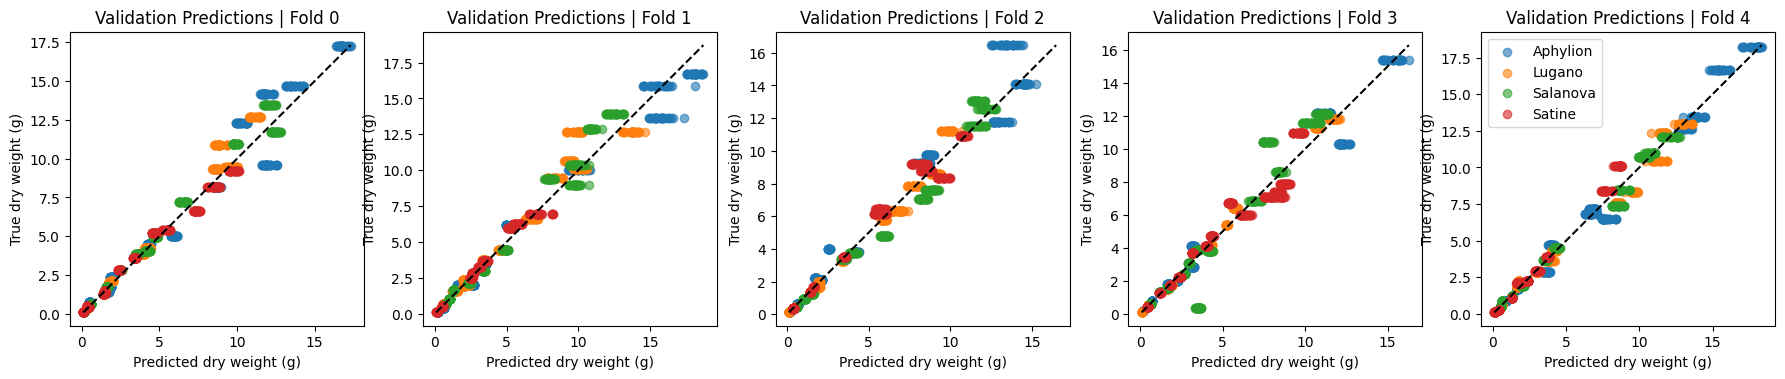

In [38]:
import numpy as np
import matplotlib.pyplot as plt

variety_names = {i: v for i, v in enumerate(varieties)}

plt.figure(figsize=(22, 8))

for fold_index in range(FOLDS):

    # Load saved fold predictions

    preds = pred_by_fold[fold_index]
    targets = target_by_fold[fold_index]
    varieties = varieties_by_fold[fold_index]  # integer indices

    unique_varieties = np.unique(varieties)

    plt.subplot(1, FOLDS, fold_index + 1)

    for v in unique_varieties:
        mask = varieties == v
        plt.scatter(
            preds[mask],
            targets[mask],
            alpha=0.6,
            label=variety_names.get(int(v), f"Variety {v}")
        )

    # Identity line
    min_val = min(preds.min(), targets.min())
    max_val = max(preds.max(), targets.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')

    plt.xlabel("Predicted dry weight (g)")
    plt.ylabel("True dry weight (g)")
    plt.title("Validation Predictions | Fold {}".format(fold_index))

    plt.gca().set_aspect('equal', adjustable='box')

plt.legend()
plt.show()


---
---


# Test calibration opportunity

In [44]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def tail_calibration_mae(y_pred, y_true, threshold=10.0, scale=1.2, shift=0.0):
    """
    Calibrate high-end predictions and calculate MAE.

    Parameters
    ----------
    y_pred : np.array
        Model predictions (normal units, not log).
    y_true : np.array
        Ground truth values (normal units).
    threshold : float
        Predictions above this value will be scaled/shifted.
    scale : float
        Multiplicative factor for predictions above threshold.
    shift : float
        Additive factor for predictions above threshold.
    
    Returns
    -------
    calibrated_preds : np.array
        Adjusted predictions.
    mae : float
        MAE between calibrated predictions and true values.
    """
    y_cal = y_pred.copy()
    mask = y_cal > threshold
    y_cal[mask] = y_cal[mask] * scale + shift

    mae = mean_absolute_error(y_true, y_cal)
    return y_cal, mae


In [63]:
# Analyse single fold
fold_to_analyze = 0

preds = pred_by_fold[fold_to_analyze]
targets = target_by_fold[fold_to_analyze]
varieties = varieties_by_fold[fold_to_analyze]  # integer indices
image_ids = image_ids_by_fold[fold_to_analyze]

idx_to_variety = {i: v for i, v in enumerate(variety_to_idx)}



# Calibration 
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# Create a container for the results
best_params_by_variety = {}

# Convert lists to arrays for easier masking
preds_arr = np.array(preds)
targets_arr = np.array(targets)
varieties_arr = np.array(varieties)
unique_varieties = np.unique(varieties_arr)

for var in unique_varieties:
    print(f"Optimizing for variety: {idx_to_variety[var]}")
    
    # Filter data just for this variety
    v_mask = varieties_arr == var
    v_preds = preds_arr[v_mask]
    v_targets = targets_arr[v_mask]
    
    # Grid search results for THIS variety
    v_results = []
    
    # Using your original search ranges
    for t in np.arange(8.0, 12.0, 0.5):
        for sc in np.arange(1.0, 1.5, 0.05):
            for sh in np.arange(-2.0, 2.0, 0.25):
                # Call your original function on the variety subset
                _, cal_mae = tail_calibration_mae(v_preds, v_targets, threshold=t, scale=sc, shift=sh)
                
                v_results.append({
                    'threshold': t, 
                    'scale': sc, 
                    'shift': sh, 
                    'MAE': cal_mae
                })
    
    # Find the best for this variety
    v_df = pd.DataFrame(v_results).sort_values('MAE').reset_index(drop=True)
    best_params_by_variety[var] = v_df.iloc[0].to_dict()
    
    print(f"Best for {var}: MAE={v_df.iloc[0]['MAE']:.4f} "
          f"(T={v_df.iloc[0]['threshold']}, Sc={v_df.iloc[0]['scale']:.2f}, Sh={v_df.iloc[0]['shift']:.2f})")

# Final combined result logic
print("\n--- Final Strategy ---")
for var, params in best_params_by_variety.items():
    print(f"Variety {idx_to_variety[var]}: Use Threshold {params['threshold']}, Scale {params['scale']:.2f}, Shift {params['shift']:.2f}")

Optimizing for variety: Aphylion
Best for 0: MAE=0.7594 (T=9.0, Sc=1.00, Sh=1.00)
Optimizing for variety: Lugano
Best for 1: MAE=0.3992 (T=8.0, Sc=1.15, Sh=-0.50)
Optimizing for variety: Salanova
Best for 2: MAE=0.3539 (T=8.0, Sc=1.00, Sh=1.00)
Optimizing for variety: Satine
Best for 3: MAE=0.2165 (T=8.5, Sc=1.00, Sh=-0.50)

--- Final Strategy ---
Variety Aphylion: Use Threshold 9.0, Scale 1.00, Shift 1.00
Variety Lugano: Use Threshold 8.0, Scale 1.15, Shift -0.50
Variety Salanova: Use Threshold 8.0, Scale 1.00, Shift 1.00
Variety Satine: Use Threshold 8.5, Scale 1.00, Shift -0.50


In [62]:
def calculate_overall_calibrated_mae(preds, targets, varieties, best_params_by_variety):
    """
    Calculates the total MAE by applying the variety-specific best parameters.
    """
    final_calibrated_preds = np.zeros_like(preds)
    
    for var in np.unique(varieties):
        v_mask = (varieties == var)
        v_preds = preds[v_mask]
        
        # Retrieve best params found in the previous grid search
        p = best_params_by_variety[var]
        
        # Apply the specific calibration for this variety
        # Using your original tail_calibration_mae logic on the subset
        v_cal, _ = tail_calibration_mae(
            v_preds, 
            targets[v_mask], # targets[v_mask] is needed here to satisfy the function signature
            threshold=p['threshold'], 
            scale=p['scale'], 
            shift=p['shift']
        )
        
        final_calibrated_preds[v_mask] = v_cal

    # Final overall MAE calculation
    overall_mae = mean_absolute_error(targets, final_calibrated_preds)
    return final_calibrated_preds, overall_mae

# Execute
final_preds, total_mae = calculate_overall_calibrated_mae(
    preds_arr, targets_arr, varieties_arr, best_params_by_variety
)

print(f"--- Calibration Results ---")
print(f"Original Ensemble MAE: {mean_absolute_error(targets_arr, preds_arr):.4f}")
print(f"Variety-Calibrated MAE: {total_mae:.4f}")
print(f"Improvement: {mean_absolute_error(targets_arr, preds_arr) - total_mae:.4f}")

--- Calibration Results ---
Original Ensemble MAE: 0.5177
Variety-Calibrated MAE: 0.4589
Improvement: 0.0588


In [49]:
# Gradual tail calibration

def gradual_tail_calibration_mae(y_pred, y_true, threshold=10.0, scale=1.2, shift=0.0):
    """
    Gradually scales the excess weight above a threshold.
    
    Formula: y_cal = threshold + (y_pred - threshold) * scale + shift
    """
    y_cal = y_pred.copy()
    mask = y_cal > threshold
    
    # Only the 'excess' weight is multiplied by the scale
    # This ensures y_cal == threshold + shift when y_pred == threshold
    y_cal[mask] = threshold + (y_cal[mask] - threshold) * scale + shift

    mae = mean_absolute_error(y_true, y_cal)
    return y_cal, mae

In [50]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# Create a container for the results
best_params_by_variety = {}

# Convert lists to arrays for easier masking
preds_arr = np.array(preds)
targets_arr = np.array(targets)
varieties_arr = np.array(varieties)
unique_varieties = np.unique(varieties_arr)

for var in unique_varieties:
    print(f"Optimizing for variety: {idx_to_variety[var]}")
    
    # Filter data just for this variety
    v_mask = varieties_arr == var
    v_preds = preds_arr[v_mask]
    v_targets = targets_arr[v_mask]
    
    # Grid search results for THIS variety
    v_results = []
    
    # Using your original search ranges
    for t in np.arange(8.0, 12.0, 0.5):
        for sc in np.arange(1.0, 1.5, 0.05):
            for sh in np.arange(-2.0, 2.0, 0.25):
                # Call your original function on the variety subset
                _, cal_mae = gradual_tail_calibration_mae(v_preds, v_targets, threshold=t, scale=sc, shift=sh)
                
                v_results.append({
                    'threshold': t, 
                    'scale': sc, 
                    'shift': sh, 
                    'MAE': cal_mae
                })
    
    # Find the best for this variety
    v_df = pd.DataFrame(v_results).sort_values('MAE').reset_index(drop=True)
    best_params_by_variety[var] = v_df.iloc[0].to_dict()
    
    print(f"Best for {var}: MAE={v_df.iloc[0]['MAE']:.4f} "
          f"(T={v_df.iloc[0]['threshold']}, Sc={v_df.iloc[0]['scale']:.2f}, Sh={v_df.iloc[0]['shift']:.2f})")

# Final combined result logic
print("\n--- Final Strategy ---")
for var, params in best_params_by_variety.items():
    print(f"Variety {idx_to_variety[var]}: Use Threshold {params['threshold']}, Scale {params['scale']:.2f}, Shift {params['shift']:.2f}")

Optimizing for variety: Aphylion
Best for 0: MAE=0.7594 (T=9.5, Sc=1.00, Sh=1.00)
Optimizing for variety: Lugano
Best for 1: MAE=0.4000 (T=8.0, Sc=1.15, Sh=0.75)
Optimizing for variety: Salanova
Best for 2: MAE=0.3539 (T=9.0, Sc=1.00, Sh=1.00)
Optimizing for variety: Satine
Best for 3: MAE=0.2165 (T=8.5, Sc=1.00, Sh=-0.50)

--- Final Strategy ---
Variety Aphylion: Use Threshold 9.5, Scale 1.00, Shift 1.00
Variety Lugano: Use Threshold 8.0, Scale 1.15, Shift 0.75
Variety Salanova: Use Threshold 9.0, Scale 1.00, Shift 1.00
Variety Satine: Use Threshold 8.5, Scale 1.00, Shift -0.50


In [51]:
def calculate_overall_calibrated_mae(preds, targets, varieties, best_params_by_variety):
    """
    Calculates the total MAE by applying the variety-specific best parameters.
    """
    final_calibrated_preds = np.zeros_like(preds)
    
    for var in np.unique(varieties):
        v_mask = (varieties == var)
        v_preds = preds[v_mask]
        
        # Retrieve best params found in the previous grid search
        p = best_params_by_variety[var]
        
        # Apply the specific calibration for this variety
        # Using your original tail_calibration_mae logic on the subset
        v_cal, _ = gradual_tail_calibration_mae(
            v_preds, 
            targets[v_mask], # targets[v_mask] is needed here to satisfy the function signature
            threshold=p['threshold'], 
            scale=p['scale'], 
            shift=p['shift']
        )
        
        final_calibrated_preds[v_mask] = v_cal

    # Final overall MAE calculation
    overall_mae = mean_absolute_error(targets, final_calibrated_preds)
    return final_calibrated_preds, overall_mae

# Execute
final_preds, total_mae = calculate_overall_calibrated_mae(
    preds_arr, targets_arr, varieties_arr, best_params_by_variety
)

print(f"--- Calibration Results ---")
print(f"Original Ensemble MAE: {mean_absolute_error(targets_arr, preds_arr):.4f}")
print(f"Variety-Calibrated MAE: {total_mae:.4f}")
print(f"Improvement: {mean_absolute_error(targets_arr, preds_arr) - total_mae:.4f}")

--- Calibration Results ---
Original Ensemble MAE: 0.5336
Variety-Calibrated MAE: 0.4299
Improvement: 0.1037


In [53]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

def power_tail_calibration_mae(y_pred, y_true, threshold=10.0, scale=1.1, gamma=1.0, shift=0.0):
    """
    Gradual power-law calibration:
    y_cal = threshold + ((y_pred - threshold) * scale)^gamma + shift
    """
    y_cal = y_pred.copy()
    mask = y_cal > threshold
    
    # Calculate scaled excess
    excess = (y_cal[mask] - threshold) * scale
    
    # Apply power transformation to excess and re-add to threshold
    # np.maximum handles potential floating point noise below zero
    y_cal[mask] = threshold + np.power(np.maximum(1e-8, excess), gamma) + shift

    mae = mean_absolute_error(y_true, y_cal)
    return y_cal, mae

# Container for results
best_params_by_variety = {}

# Convert to arrays
preds_arr = np.array(preds)
targets_arr = np.array(targets)
varieties_arr = np.array(varieties)
unique_varieties = np.unique(varieties_arr)

for var in unique_varieties:
    var_name = idx_to_variety[var]
    print(f"Optimizing for variety: {var_name}")
    
    v_mask = varieties_arr == var
    v_preds = preds_arr[v_mask]
    v_targets = targets_arr[v_mask]
    
    v_results = []
    
    # Grid search - adding Gamma for curvature
    for t in np.arange(8.0, 12.0, 0.5):
        for sc in np.arange(1.0, 1.4, 0.05): # Tightened scale slightly for power stability
            for gm in np.arange(1.0, 1.3, 0.1): # The new curvature parameter
                for sh in np.arange(-1.0, 1.0, 0.25): # Tightened shift range
                    
                    _, cal_mae = power_tail_calibration_mae(
                        v_preds, v_targets, 
                        threshold=t, scale=sc, gamma=gm, shift=sh
                    )
                    
                    v_results.append({
                        'threshold': t, 
                        'scale': sc, 
                        'gamma': gm,
                        'shift': sh, 
                        'MAE': cal_mae
                    })
    
    # Sort and store
    v_df = pd.DataFrame(v_results).sort_values('MAE').reset_index(drop=True)
    best_params_by_variety[var] = v_df.iloc[0].to_dict()
    
    bp = best_params_by_variety[var]
    print(f"Best for {var_name}: MAE={bp['MAE']:.4f} "
          f"(T={bp['threshold']}, Sc={bp['scale']:.2f}, Gm={bp['gamma']:.1f}, Sh={bp['shift']:.2f})")

# Final Strategy Output
print("\n--- Final Strategy ---")
for var, params in best_params_by_variety.items():
    print(f"Variety {idx_to_variety[var]}: T={params['threshold']}, "
          f"Scale={params['scale']:.2f}, Gamma={params['gamma']:.1f}, Shift={params['shift']:.2f}")

Optimizing for variety: Aphylion
Best for Aphylion: MAE=0.7668 (T=9.5, Sc=1.00, Gm=1.0, Sh=0.75)
Optimizing for variety: Lugano
Best for Lugano: MAE=0.3985 (T=8.0, Sc=1.00, Gm=1.1, Sh=0.75)
Optimizing for variety: Salanova
Best for Salanova: MAE=0.3650 (T=8.0, Sc=1.05, Gm=1.0, Sh=0.75)
Optimizing for variety: Satine
Best for Satine: MAE=0.2165 (T=8.5, Sc=1.00, Gm=1.0, Sh=-0.50)

--- Final Strategy ---
Variety Aphylion: T=9.5, Scale=1.00, Gamma=1.0, Shift=0.75
Variety Lugano: T=8.0, Scale=1.00, Gamma=1.1, Shift=0.75
Variety Salanova: T=8.0, Scale=1.05, Gamma=1.0, Shift=0.75
Variety Satine: T=8.5, Scale=1.00, Gamma=1.0, Shift=-0.50


In [54]:
def calculate_overall_calibrated_mae(preds, targets, varieties, best_params_by_variety):
    """
    Calculates the total MAE by applying the variety-specific best power-law parameters.
    """
    final_calibrated_preds = np.zeros_like(preds)
    
    for var in np.unique(varieties):
        v_mask = (varieties == var)
        if not np.any(v_mask):
            continue
            
        v_preds = preds[v_mask]
        
        # Retrieve best params (threshold, scale, gamma, shift)
        p = best_params_by_variety[var]
        
        # Apply the Power-Law calibration for this variety
        v_cal, _ = power_tail_calibration_mae(
            v_preds, 
            targets[v_mask], 
            threshold=p['threshold'], 
            scale=p['scale'],
            gamma=p['gamma'],
            shift=p['shift']
        )
        
        final_calibrated_preds[v_mask] = v_cal

    # Final overall MAE calculation
    overall_mae = mean_absolute_error(targets, final_calibrated_preds)
    return final_calibrated_preds, overall_mae

# Execute
final_preds, total_mae = calculate_overall_calibrated_mae(
    preds_arr, targets_arr, varieties_arr, best_params_by_variety
)

print(f"--- Power-Law Calibration Results ---")
print(f"Original Ensemble MAE: {mean_absolute_error(targets_arr, preds_arr):.4f}")
print(f"Variety-Calibrated MAE: {total_mae:.4f}")
print(f"Total Net Improvement: {mean_absolute_error(targets_arr, preds_arr) - total_mae:.4f}g")

--- Power-Law Calibration Results ---
Original Ensemble MAE: 0.5336
Variety-Calibrated MAE: 0.4344
Total Net Improvement: 0.0992g
